# ReferentialGym Tutorials: Creating New Modules



## Installation

In [ ]:
!git clone https://github.com/Near32/ReferentialGym.git ; cd ReferentialGym; git checkout master; git pull; git status; pip install -e . 

Cloning into 'ReferentialGym'...
remote: Enumerating objects: 28, done.
remote: Counting objects: 100% (28/28), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 2425 (delta 12), reused 1 (delta 0), pack-reused 2397
Receiving objects: 100% (2425/2425), 29.83 MiB | 11.04 MiB/s, done.
Resolving deltas: 100% (1807/1807), done.
Already on 'master'
Your branch is up to date with 'origin/master'.
Already up to date.
On branch master
Your branch is up to date with 'origin/master'.

nothing to commit, working tree clean
Obtaining file:///content/ReferentialGym
     |████████████████████████████████| 7.3MB 14.0MB/s 
     |████████████████████████████████| 317kB 51.8MB/s 
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1
  Running setup.py develop for ReferentialGym


IMPORTANT: 
Before continuing any further, please restart the kernel (Runtime->restart runtime) in order to make the installed packaged available.

In [ ]:
import ReferentialGym

During importation of 3DShapesPyBulletDataset:No module named 'pybullet'
Please install pybullet if you want to use the 3DShapesPyBulletDataset.
During importation of MineRLDataset:No module named 'minerl'
Please install minerl if you want to use the MineRLDataset.


# Preliminaries:

In the following, you will be guided towards building modules for either extending some agents' architecture or for the purpose of interfacing a new metric in the computational graph of a discriminative referential game.

Before doing any of this, it is important to highlight some architectural choices that have been made when building the framework and that enables some valuable features for you to leverage when creating new modules.



The figure below details an UML diagram of the ReferentialGym framework. Most importantly, it highlights how the modules relate to each other via the `StreamHandler` class and its `placeholders` attribute which holds every possible Data Streams at any given time.

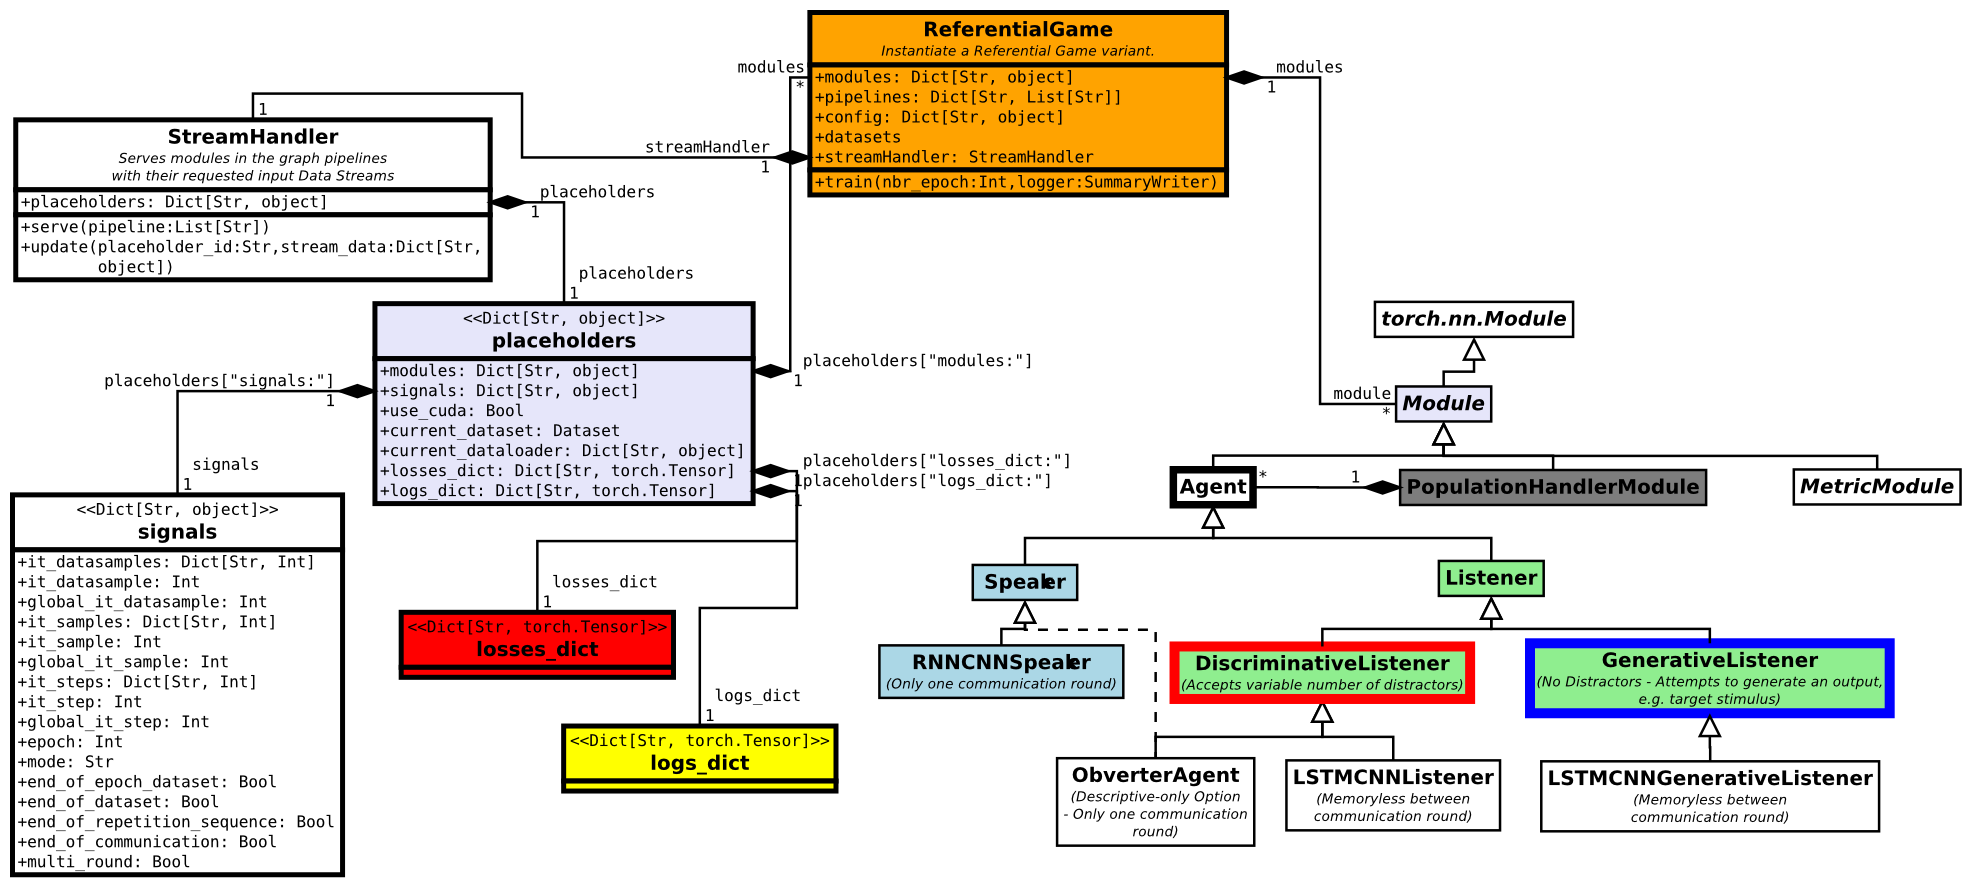

## Everything is a Data Stream!

The framework implements a powerful abstraction, in which modules can also be considered as possible input data streams to another module, thereby allowing some modules to operate on some other modules.
The current main purpose of this abstraction is to enable using a culture of agents via an instance of the `PopulationHandlerModule` class, that has been introduced in the Getting Started tutorial.


The following code highlights how the `PopulationHandledModule` class is configured to request some modules as its input data stream (do not run the cell):

In [ ]:
rg_config = {}
# Configuration dictionnary for the Referential Game that is currently being built.
# The Getting Started tutorial explains how this is done.

# Current Speaker:
current_speaker_id = "current_speaker"
# Current Listener:
current_listener_id = "current_listener"

modules[current_speaker_id] = rg_modules.CurrentAgentModule(id=current_speaker_id,role="speaker")
modules[current_listener_id] = rg_modules.CurrentAgentModule(id=current_listener_id,role="listener")

# The previous modules are the placeholders for agents to play some rounds of 
# the referential game graph that we are currently building. 
# The PopulationHandlerModule instance will operate onto them as they will
# be requested as part of its input Data Stream:

population_handler_id = "population_handler_0"
population_handler_config = copy.deepcopy(rg_config)
population_handler_config["verbose"] = True 
# If True, the PopulationHandlerModule will provide some timely information about what
# is happening to the agents in the population (e.g. resetting, when replicating
# a iterated learning model approach...) 

# This is where the magic happens: 
population_handler_stream_ids = {
  "current_speaker_streams_dict":"modules:current_speaker",
  "current_listener_streams_dict":"modules:current_listener",
  "epoch":"signals:epoch",
  "mode":"signals:mode",
  "global_it_datasample":"signals:global_it_datasample",
}
# The StreamHandler that serves each module their requested input Data Streams
# has access to all the modules. 
# They are organised as a dictionnary where keys have to be their unique 
# `module_id` defined by the user (as seen above for current_speaker and 
# current_listener modules) and values are the module themselves. 

modules[population_handler_id] = rg_modules.build_PopulationHandlerModule(
    id=population_handler_id,
    prototype_speaker=speaker,
    prototype_listener=listener,
    config=population_handler_config,
    input_stream_ids=population_handler_stream_ids)



As it can be seen, the `':'` separator is protected and used to specify to the `StreamHandler` paths to different Data Steam.

## Everything is Accessible/Public to the StreamHandler!

As seen above, it is possible for a module to request another module as part of its input Data Streams, but it is also possible to request an attribute of any other module the same way.

The following details how to instantiate a FactorVAE-Disentanglement metric for a disentanglement score to be computed onto the `cnn_encoder` attribute of the `current_speaker` module's submodule (i.e. the actual agent that the `PopulationHandlerModule` has placed in this placeholder) (do not run the cell):


In [ ]:
speaker_factor_vae_disentanglement_metric_id = "speaker_factor_vae_disentanglement_metric"
speaker_factor_vae_disentanglement_metric_input_stream_ids = {
  "model":"modules:current_speaker:ref:ref_agent:cnn_encoder",
  "representations":"modules:current_speaker:ref:ref_agent:features",
  "experiences":"current_dataloader:sample:speaker_experiences", 
  "latent_representations":"current_dataloader:sample:speaker_exp_latents", 
  "latent_values_representations":"current_dataloader:sample:speaker_exp_latents_values",
  "indices":"current_dataloader:sample:speaker_indices", 
}
speaker_factor_vae_disentanglement_metric_module = rg_modules.build_FactorVAEDisentanglementMetricModule(
  id=speaker_factor_vae_disentanglement_metric_id,
  input_stream_ids=speaker_factor_vae_disentanglement_metric_input_stream_ids,
  config = {
    "epoch_period":args.metric_epoch_period,
    # interval in epoch between which the metric is computed 
    # (it is still computed solely over the current epoch's data, though.)
    "batch_size":64, 
    # batch size to use to train the classifier.
    "nbr_train_points":10000, 
    # how many sample from the current epoch to use to train the classifier.
    "nbr_eval_points":5000,
    # how many of the remaining sample from the current epoch to use 
    # generate the disentanglement score.
    "resample":False,
    "threshold":5e-2,
    "random_state_seed":args.seed,
    "verbose":False,
    "active_factors_only":True,
  }
)
modules[speaker_factor_vae_disentanglement_metric_id] = speaker_factor_vae_disentanglement_metric_module


As it can be seen in the first entries of `speaker_factor_vae_disentanglement_metric_input_stream_ids` dictionnary, a `"model"` is requested. This is the model (assumed to be a CNN) on which the disentanglement score will be computed.

This model is an attribute of the `current_speaker`-ided module's `ref` attribute's `ref_agent`: `"modules:current_speaker:ref:ref_agent:cnn_encoder"`.

No matter how deep an attribute is, if it is part of a module, it can be accessed by the `StreamHandler`.

## Advanced usage:

The `StreamHandler` can also perform some pre-processing on the input Data Streams that can be requested. The dedicated separator is the dot, `'.'`.

Any (argument-free) method of the object being requested as part of the input Data Stream can be applied onto the object before the requesting module operates on it.

For instance, when instantiating an `DifferentiableObverterAgent`, in order to prevent the gradient from flowing back from the `current_listener` to the `current_speaker`, the PyTorch Tensor-specific method `detach()` is called by the `StreamHandler`. This is done by requesting said input Data Stream the following way (see in [differentiable_obverter_agent.py:line157](https://github.com/Near32/ReferentialGym/blob/4686642c8712dcd96f0ba28a5dac25c547f462b7/ReferentialGym/agents/differentiable_obverter_agent.py#L157)) (do not run the cell):

In [ ]:
self.input_stream_ids['listener'].update({
    'sentences_one_hot':'modules:current_speaker:sentences_one_hot.detach',
    'sentences_widx':'modules:current_speaker:sentences_widx.detach', 
})

## How to provide context to a module's computation?

Given the blackbox approach with which each module are handled by the `StreamHandler`, it can be important for said module to be provided context about its execution. Remember that all pipelines (and therefore all modules) are being executed at each iteration/round of the referential game. In other words, the time granularity follows the granularity of the data being sampled from the dataset and each module can perform computation at this time scale.

Below is replicated the main method of the `ReferentialGame` class, the `train` method, in order to highlights its main loop and its different inner loops, e.g. epoch loop, mode loop (`"test"` or `"train"`, for instance), dataset loop (actually sampling batches of data from the dataloader/dataset), referential game communication round loop (i.e. when the agents are being given more than 1 round of communication), data sampled's repetition loop (it can be interesting in some application to have the module operate multiple times on the same data sample...):  

In [ ]:
class ReferentialGame:
  
  (...)

  def train(self, nbr_epoch: int = 10, logger: SummaryWriter = None, verbose_period=None):
        # Dataset:
        if 'batch_size' not in self.config:
            self.config['batch_size'] = 32
        if 'dataloader_num_worker' not in self.config:
            self.config['dataloader_num_worker'] = 8

        print("Create dataloader: ...")
        
        data_loaders = {mode:torch.utils.data.DataLoader(
              dataset,
              batch_size=self.config['batch_size'],
              shuffle=True,
              collate_fn=collate_dict_wrapper,
              pin_memory=True,
              num_workers=self.config['dataloader_num_worker']
            )
            for mode, dataset in self.datasets.items()
        }
        
        print("Create dataloader: OK.")
        
        print("Launching training: ...")

        it_datasamples = self.stream_handler['signals:it_datasamples']
        if it_datasamples is None:  it_datasamples = {mode:0 for mode in self.datasets} 
        # counting the number of data sampled from dataloaders
        
        it_samples = self.stream_handler['signals:it_samples']
        if it_samples is None:  it_samples = {mode:0 for mode in self.datasets} 
        # counting the number of multi-round
        
        it_steps = self.stream_handler['signals:it_steps']
        if it_steps is None:    it_steps = {mode:0 for mode in self.datasets} 
        # taking into account multi round... counting the number of sample shown to the agents.
        
        pbar = tqdm(total=nbr_epoch)
        if logger is not None:
            self.stream_handler.update("modules:logger:ref", logger)
        
        self.stream_handler.update("signals:use_cuda", self.config['use_cuda'])
        
        init_epoch = self.stream_handler["signals:epoch"]
        if init_epoch is None: 
            init_epoch = 0
        else:
            pbar.update(init_epoch)

        # //------------------------------------------------------------//
        # //---------------------EPOCH LOOP:-----------------------------//
        # //------------------------------------------------------------// 
        
        for epoch in range(init_epoch,nbr_epoch):
            self.stream_handler.update("signals:epoch", epoch)
            pbar.update(1)
            
            # //------------------------------------------------------------//
            # //----------------------MODE LOOP:-----------------------------//
            # //------------------------------------------------------------//
            
            for it_dataset, (mode, data_loader) in enumerate(data_loaders.items()):
                self.stream_handler.update("current_dataset:ref", self.datasets[mode])
                self.stream_handler.update("signals:mode", mode)
                
                end_of_epoch_dataset = (it_dataset==len(data_loaders)-1)
                self.stream_handler.update("signals:end_of_epoch_dataset", end_of_epoch_dataset)
                
                nbr_experience_repetition = 1
                if 'nbr_experience_repetition' in self.config\
                    and 'train' in mode:
                    nbr_experience_repetition = self.config['nbr_experience_repetition']

                # //------------------------------------------------------------//
                # //--------------------DATASET LOOP:----------------------------//
                # //------------------------------------------------------------//
                
                for idx_stimulus, sample in enumerate(data_loader):
                    end_of_dataset = (idx_stimulus==len(data_loader)-1)
                    self.stream_handler.update("signals:end_of_dataset", end_of_dataset)
                    it_datasamples[mode] += 1
                    it_datasample = it_datasamples[mode]
                    self.stream_handler.update("signals:it_datasamples", it_datasamples)
                    self.stream_handler.update("signals:global_it_datasample", it_datasample)
                    self.stream_handler.update("signals:it_datasample", idx_stimulus)
                    it = it_datasample


                    if self.config['use_cuda']:
                        sample = sample.cuda()

                    # //------------------------------------------------------------//
                    # //----------------------DATA REPETITION LOOP:----------------------//
                    # //------------------------------------------------------------//
                    
                    for it_rep in range(nbr_experience_repetition):
                        it_samples[mode] += 1
                        it_sample = it_samples[mode]
                        self.stream_handler.update("signals:it_samples", it_samples)
                        self.stream_handler.update("signals:global_it_sample", it_sample)
                        self.stream_handler.update("signals:it_sample", it_rep)
                        end_of_repetition_sequence = (it_rep==nbr_experience_repetition-1)
                        self.stream_handler.update("signals:end_of_repetition_sequence", end_of_repetition_sequence)
                        
                        # //------------------------------------------------------------//
                        # //----------------COMMUNICATION ROUND LOOP:--------------------//
                        # //------------------------------------------------------------//
                        
                        for idx_round in range(self.config['nbr_communication_round']):
                            it_steps[mode] += 1
                            it_step = it_steps[mode]
                            
                            self.stream_handler.update("signals:it_steps", it_steps)
                            self.stream_handler.update("signals:global_it_step", it_step)
                            self.stream_handler.update("signals:it_step", idx_round)
                            
                            end_of_communication = (idx_round==self.config['nbr_communication_round']-1)
                            self.stream_handler.update("signals:end_of_communication", end_of_communication)
                            
                            multi_round = True
                            if end_of_communication:
                                multi_round = False
                            self.stream_handler.update("signals:multi_round", multi_round)
                            self.stream_handler.update('current_dataloader:sample', sample)

                            for pipe_id, pipeline in self.pipelines.items():
                                if "referential_game" in pipe_id: 
                                    self.stream_handler.serve(pipeline)

                        # //------------------------------------------------------------//
                        # //----------------END::COMMUNICATION ROUND LOOP---------------//
                        # //------------------------------------------------------------//
                        

                        # //------------------------------------------------------------//
                        # //------------------DEFAULT PIPELINES LOOP:-------------------//
                        # //------------------------------------------------------------//

                        for pipe_id, pipeline in self.pipelines.items():
                            if "referential_game" not in pipe_id:
                                self.stream_handler.serve(pipeline)
                        
                        # //------------------------------------------------------------//
                        # //---------------END::DEFAULT PIPELINES LOOP------------------//
                        # //------------------------------------------------------------//
                        
                        losses = self.stream_handler["losses_dict"]
                        loss = sum( [l[-1] for l in losses.values()])
                        logs_dict = self.stream_handler["logs_dict"]
                        acc_keys = [k for k in logs_dict.keys() if '/referential_game_accuracy' in k]
                        if len(acc_keys):
                            acc = logs_dict[acc_keys[-1]].mean()

                        if verbose_period is not None and idx_stimulus % verbose_period == 0:
                            descr = 'Epoch {} :: {} Iteration {}/{} :: Loss {} = {}'.format(
                                epoch+1, mode, idx_stimulus+1, len(data_loader), it+1, loss.item())
                            pbar.set_description_str(descr)
                        
                        self.stream_handler.reset("losses_dict")
                        self.stream_handler.reset("logs_dict")
        
                    # //------------------------------------------------------------//
                    # //--------------------END::DATA REPETITION LOOP-------------------//
                    # //------------------------------------------------------------//
                    
                if logger is not None:
                    # the logger records the different modes of execution
                    # as different epoch:
                    logger.switch_epoch()
                    
                # //------------------------------------------------------------//
                # //------------------END::DATASET LOOP-------------------------//
                # //------------------------------------------------------------//
                
            if self.save_epoch_interval is not None\
             and epoch % self.save_epoch_interval == 0:
                self.save(path=self.save_path)

            # //------------------------------------------------------------//
            # //-------------------END::MODE LOOP---------------------------//
            # //------------------------------------------------------------//
            
        # //------------------------------------------------------------//
        # //--------------------END::EPOCH LOOP-------------------------//
        # //------------------------------------------------------------//
        
        return

Note that only the modules in the pipeline with id `referential_game` have effectively a granularity that goes has far as the referential game's communication rounds. The modules in the other pipelines are handled after this specific pipeline with a time granularity just above that.

In effect, it means that any modules outside of the `referential_game` pipeline will not have access to the output streams of the modules of latter pipeline before they reached their final state. This is by design: for instance, in a multi-round referential game, the listener's output streams at round 1 might only be intermediary values that will change as the conversation with the speaker unfolds in the subsequent communication rounds.



Finally, as seen in the UML diagram above, there is a specific entry to the `StreamHandler`'s placeholders under the path `"signals:"` that defines a set of data streams that describe the current level of execution of the different loops. By requesting the relevant signals, a module can be provided with context.

# CustomMetricModule

In the following, we detail how to implement a custom module that aims to perform a given measure.

Firstly, note that all module must inherit from the `Module` class below reproduced (import it from `referential_gym.modules`, do not run the following cell):

In [ ]:
import torch
import torch.nn as nn 

class Module(nn.Module):
    def __init__(self,
                 id:str,
                 type:str,
                 config:Dict[str,object],
                 input_stream_ids:Dict[str,str]):
        super(Module, self).__init__()
        self.id = id
        self.type = type
        self.config = config
        self.input_stream_ids = input_stream_ids

    def get_id(self) -> str:
        return self.id

    def get_type(self) -> str:
        return self.type 

    def get_input_stream_ids(self) -> Dict[str,str]:
        return self.input_stream_ids

    def compute(self, inputs_dict:Dict[str,object]) -> Dict[str,object] :
        """
        Operates on inputs_dict that is made up of referents to the requested 
        data stream, as values of the `self.input_stream_ids` dict.
        Make sure that accesses to its element are non-destructive.
        
        :param inputs_dict: Dict[str, object] where the keys are the keys of 
                            `self.input_stream_ids`, and the values are the values
                            stored in the `StreamHandler`'s placeholder path defined
                            by the values of `self.input_stream_ids`.
        :returns:
            - outputs_sream_dict: 
        """
        raise NotImplementedError

As the interface defined by the `Module` class can be seen, everything happens in the `compute` method. The only critical element to get right before that is to specify what are the input Data Streams that the module requires to perform its computation, by passing at initialization-time a valid dictionnary as `input_streams_ids` where the keys are user-defined and will correspond to the available keys in the `inputs_dict` argument to the `compute` method. 

As already seen before, the values of the `input_streams_ids` dict are paths to a given data that the `StreamHandler` will extract at runtime and provide to the module as the corresponding values of the `inputs_dict` argument to the `compute` method.

## Providing context to a metric module?

Depending on what one might want to measure, it will be important to provide relevant context via the choice of signals from the `"signals:"` hierarchy in the `StreamHandler`'s placeholder.

Below is replicated the default `input_streams_ids` dict requested by the FactorVAE-Disentanglement metric module highlighted earlier (do not run the cell):

In [ ]:
default_input_stream_ids = {
    "logger":"modules:logger:ref",
    "logs_dict":"logs_dict",
    "epoch":"signals:epoch",
    "mode":"signals:mode",

    "end_of_dataset":"signals:end_of_dataset",  
    # boolean: whether the current batch/datasample is the last of the current dataset/mode.
    "end_of_repetition_sequence":"signals:end_of_repetition_sequence",
    # boolean: whether the current sample(observation from the agent of the current batch/datasample) 
    # is the last of the current sequence of repetition.
    "end_of_communication":"signals:end_of_communication",
    # boolean: whether the current communication round is the last of 
    # the current dialogue.
    
    "dataset":"current_dataset:ref",
    "model":"modules:current_speaker:ref:ref_agent:cnn_encoder",
    "representations":"modules:current_speaker:ref:ref_agent:features",
    "experiences":"current_dataloader:sample:speaker_experiences", 
    "latent_representations":"current_dataloader:sample:speaker_exp_latents", 
    "latent_values_representations":"current_dataloader:sample:speaker_exp_latents_values",
    "indices":"current_dataloader:sample:speaker_indices", 
    
}

This metric module stores all the *different* data sample of a given epoch (accessible via the `"experiences"` entry, and also stores corresponding representations computed by the model, in the `"representations"` entry) until it is served with the last data sample of a given epoch. At this time, it computes the FactorVAE-Disentanglement score using the stored data.

The `"end_of_dataset"` signal provides the module with enough context to know whether it is seeing the last sampled batch of the current dataset. This is not enoug context yet to know whether it is time to compute the score or not.

The `"end_of_repetition_sequence"` signal provides the module with enougth context to know whether the current data sample is indeed different from all the previous one already stored during the current epoch, and, if so, then the module stores this new data sample (upon its last presentation/repetition).

The "`end_of_communication"` signal provides the final information to know whether it is time to compute the score or not.

When all the above boolean are `True`, the module will have indeed store all the different data samples of the current epoch (and mode: note that `end_of_dataset` is `True` whenever the last batch of the current dataloader/dataset is being experience before switching to a new mode of execution) after storing the current data sample, and then it will be time to proceed with the computation of the FactorVAE-Disentanglement score.

## Logging in Tensorboard

The framework makes use of [TensorboardX](https://github.com/lanpa/tensorboardX) and any module can log data by requesting the logger, whose path in the `StreamHandler`'s placeholder is: `"modules:logger:ref"`.

Another approach can be implemented when using the `PerEpochLoggerModule`, inserting it in the last position of the last pipeline created. Rather than requesting the logger, the module can request the `"logs_dict"` and write in it by making great care to not destroy any other entry (it is really just a simple dictionnary without checks...). For instance: `logs_dict[f"{mode}/{self.id}/CustomMetricScore"] = customMetricScore_value_tensor`. The key entry is then used by the logger/PerEpochLoggerModule to register the data via TensorboardX. If the value is a tensor, then statistics are registered into TensorboardX (e.g. mean, variance, quartiles, interquartile...).



## Implementation:

We present below a template for the implementation of a metric module (do not run the cell):

In [ ]:
from typing import Dict, List 

import torch
import torch.nn as nn

import numpy as np 

from ReferentialGym.modules import Module


def build_CustomMetricModule(
    id:str,
    config:Dict[str,object],
    input_stream_ids:Dict[str,str]=None) -> Module:
    return CustomMetricModule(
        id=id,
        config=config, 
        input_stream_ids=input_stream_ids
    )

class CustomMetricModule(Module):
    def __init__(
        self,
        id:str,
        config:Dict[str,object],
        input_stream_ids:Dict[str,str]=None):
      
        default_input_stream_ids = {
            #-----------------------------------------------------
            # If you want to log directly into TensorboardX, 
            # use the following:
            "logger":"modules:logger:ref",
            #-----------------------------------------------------
            #-----------------------------------------------------
            # If you want to log with statistics via 
            # the PerEpochLoggerModule, use the following:
            "logs_dict":"logs_dict",
            #-----------------------------------------------------
            # Since each epoch contains at least a 'train' and
            # a 'test' mode of execution, it would be good to
            # be able to differentiate when are the measure
            # actually computed. Use the following signal
            # to differentiate:
            "mode":"signals:mode",
            #-----------------------------------------------------
            #-----------------------------------------------------
            
            #-----------------------------------------------------
            # To check when to compute the metric score,
            # request the following signals:
            "epoch":"signals:epoch",
            "end_of_dataset":"signals:end_of_dataset",  
            # boolean: whether the current batch/datasample is the last of the current dataset/mode.
            "end_of_repetition_sequence":"signals:end_of_repetition_sequence",
            # boolean: whether the current sample(observation from the agent of the current batch/datasample) 
            # is the last of the current sequence of repetition.
            "end_of_communication":"signals:end_of_communication",
            # boolean: whether the current communication round is the last of 
            # the current dialog.
            #-----------------------------------------------------
            
            #------------------------------------------------------
            #------------------------------------------------------
            # Add below the input data stream the metric requires:
            # for instance ...
            #------------------------------------------------------
            #------------------------------------------------------

            "dataset":"current_dataset:ref",
            "vocab_size":"config:vocab_size",
            "max_sentence_length":"config:max_sentence_length",
            "sentences_widx":"modules:current_speaker:sentences_widx", 
            "decision_probs":"modules:current_listener:decision_probs",
            "listener_indices":"current_dataloader:sample:listener_indices",

            #------------------------------------------------------
            #------------------------------------------------------
        }
        if input_stream_ids is None:
            input_stream_ids = default_input_stream_ids
        else:
            for default_stream, default_id in default_input_stream_ids.items():
                if default_id not in input_stream_ids.values():
                    input_stream_ids[default_stream] = default_id

        super(CustomMetricModule, self).__init__(
            id=id,
            type="CustomMetricModule",
            config=config,
            input_stream_ids=input_stream_ids
        )
        
        #------------------------------------------------------
        #------------------------------------------------------
        # Add below the storages required:
        # for instance ...
        #------------------------------------------------------
        #------------------------------------------------------

        self.sentences_widx = []
        self.decision_probs = []
        self.listener_indices = []

        #------------------------------------------------------
        #------------------------------------------------------

        self.end_of_ = [key for key,value in input_stream_ids.items() if "end_of_" in key]

    def _compute_metric(self):
        #------------------------------------------------------
        #------------------------------------------------------
        # Implement below your metric:
        #------------------------------------------------------
        #------------------------------------------------------
        pass
        #------------------------------------------------------
        #------------------------------------------------------

    def compute(self, input_streams_dict:Dict[str,object]) -> Dict[str,object] :
        """
        """
        outputs_stream_dict = {}


        logs_dict = input_streams_dict["logs_dict"]
        mode = input_streams_dict["mode"]
        epoch = input_streams_dict["epoch"]
        
        #------------------------------------------------------
        # In case your metric is computationally-heavy,
        # it might be interesting to not compute it at 
        # each period but rather in a given interval,
        # as proposed below:
        #------------------------------------------------------
                
        if not("epoch_period" in self.config) or epoch % self.config["epoch_period"] == 0:
            
            #------------------------------------------------------
            #------------------------------------------------------
            # Storing relevant data:
            # for instance ...
            #------------------------------------------------------
            #------------------------------------------------------
            
            sentences_widx = input_streams_dict["sentences_widx"]
            self.sentences_widx.append(sentences_widx.cpu().detach().long().numpy())
            # (1, batch_size, max_sentence_length, 1) 
            decision_probs = input_streams_dict["decision_probs"]
            self.decision_probs.append(decision_probs.cpu().detach().numpy())
            # (1, batch_size, nbr_stimulus) 
            listener_indices = input_streams_dict["listener_indices"]
            self.listener_indices.append(listener_indices.cpu().detach().long().numpy())
            # (1, batch_size, nbr_stimulus) 

            #------------------------------------------------------
            #------------------------------------------------------
            
            # Is it the end of the epoch?
            end_of_epoch = all([
              input_streams_dict[key]
              for key in self.end_of_]
            )
            
            #------------------------------------------------------
            #------------------------------------------------------
            
            if end_of_epoch:
                
                metric_score = self._compute_metric()

                logs_dict[f"{mode}/{self.id}/CustomMetricScore"] = metric_score
                
                #------------------------------------------------------
                #------------------------------------------------------
                # Do not forget to reset your storages below:
                # for instance ...
                #------------------------------------------------------
                #------------------------------------------------------
                self.sentences_widx = []  
                self.decision_probs = []
                self.listener_indices = []
                #------------------------------------------------------
                #------------------------------------------------------

            
        return outputs_stream_dict

Once implemented, make sure to instantiate your new module and insert it in the relevant pipeline, i.e. either the `"referential_game"` one or another, depending on when it is relevant for the metric to be computed...

# CustomArchitecturalModule

As language grounding can be used as [an auxiliary task to learn representations](https://arxiv.org/abs/2006.06666), it might be interesting to extract the learned visual features of a speaker or listener agent (or the speaker's emerging language utterances) and fine-tune them on a downstream task, or train in parallel (allowing gradients to flow from both task into the learned representations), for instance.

In the following, we will look at such an application by first detailing what is already available to use out-of-the-box and then highlighting how to extend the possibilities by implementing bespoke architectural modules. 

## Transfer from learned visual representations:

Providing a referential game graph as used in the Getting Started tutorial, it is possible to add a `VisualModule` in a `"downstream_task"` pipeline, for instance.

This module will be fed with the learned visual features of the speaker agent as follows (do not run the following cell): 

In [ ]:
from ReferentialGym import modules as rg_modules

#------------------------------------------------------------------
#------------------------------------------------------------------
# We assume a referential game configuration dict in rg_config,
# as explained in the Getting Started tutorial.
#------------------------------------------------------------------
#------------------------------------------------------------------

agent_config = dict()
agent_config['use_cuda'] = rg_config['use_cuda']
agent_config['architecture'] = rg_config['agent_architecture']
agent_config['dropout_prob'] = rg_config['dropout_prob']

# The architecture of your module can 
agent_config['cnn_encoder_channels'] = ['BN24','BN24','BN24','BN24']
agent_config['cnn_encoder_kernels'] = [3,3,3]
agent_config['cnn_encoder_strides'] = [1,2,1]
agent_config['cnn_encoder_paddings'] = [1,1,1]
agent_config['cnn_encoder_fc_hidden_units'] = [] 
# the last FC layer is provided by the cnn_encoder_feature_dim parameter below...

cnn_feature_size = 100
agent_config['cnn_encoder_feature_dim'] = cnn_feature_size
# N.B.: if cnn_encoder_fc_hidden_units is [],
# then this last parameter does not matter.
# The cnn encoder is not topped by any fully-connected layer.

agent_config['cnn_encoder_mini_batch_size'] = args.mini_batch_size


ds_vm_id = "downstream_visual_module"
ds_vm_config = copy.deepcopy(agent_config)
obs_shape = [nbr_distractors+1,nbr_stimulus, rg_config['stimulus_depth_dim'],rg_config['stimulus_resize_dim'],rg_config['stimulus_resize_dim']]
ds_vm_config['obs_shape'] = obs_shape
ds_vm_input_stream_ids = {
  "losses_dict":"losses_dict",
  "logs_dict":"logs_dict",
  "mode":"signals:mode",
  # Be very careful:
  # retrieving the features of a speaker agent might not work
  # when said agent has some fully-connected layers at the top of
  # its cnn_encoder...
  # Rather, to make sure that you will get feature maps, as
  # outputted by the CNN alone, you can request the following:
  "inputs":"modules:current_speaker:ref:ref_agent:feat_maps",
}


#(...)

# Instantiate the module in the list of all modules:
modules[baseline_vm_id] = rg_modules.build_VisualModule(
  id=ds_vm_id, 
  config=ds_vm_config,
  input_stream_ids=ds_vm_input_stream_ids,
)

# (...)

# Add the module in the relevant pipeline, for instance:
pipelines["downstream_task"] =[
  ds_vm_id
]
# As always, the 'referential_game' pipeline is always 
# executed first, therefore the "current_speaker" module
# has some relevant Data Stream to offer to this visual module.
